# Training Artificial Intelligence To Play The Beer Game
## An Approach Using Agent-based Models And Reinforcement Learning

_This notebook first provides a brief introduction to agent-based modeling and reinforcement learning. It then applies these ideas to training artificial intelligence to play the infamous Beer Game_

The infamous Beer Distribution Game was originally developed in the late 1950s by Jay Forrester at MIT to introduce the concepts of dynamic systems, in this case the dynamic system is a supply chain that delivers beer from a brewery to the end consumer. What makes the game so intriguing is that the structure of the supply chain and the rules of the game are simple, yet the resulting behavior is quite complex.

The Beer Game is well documented: our favorite description of the game is in Peter Senge’s [The Fifth Discipline](https://www.amazon.com/-/de/dp/B000SEIFKK/ref=sr_1_1?__mk_de_DE=ÅMÅŽÕÑ&keywords=fifth+discipline&qid=1584205992&sr=8-1), John Sterman’s [Business Dynamics](https://www.amazon.com/-/de/dp/007238915X/ref=sr_1_2?__mk_de_DE=ÅMÅŽÕÑ&keywords=business+dynamics&qid=1584206015&sr=8-2) analyses the game using system dynamics stock and flow models. We have provided an in-depth analysis of the game in another notebook in this repository, [Understanding The Beergame](understanding_the_beergame.ipynb).

Agent-based modeling is an approch to buildig simulation models of real-world systems. In agent-based modeling, entities are captured by agents, which show behaviour in reaction to internal or external events. We will use agents to represent the players in the beergame.

Once we have the agents, we can investigate different ordering strategies and try to find one that enables the agents to play the beergame and optimize game performance. We have provide a separate notebook in this repository, [An Agend-based Approach To Modeling The Beer Game](beergame_abm.ipynb), that walks through the various stages.

But using the agents we can do something even more interesting: Instead of giving the agents a set of predefined behaviours, we can train the agents to play the beergame using machine learning techniques, in particular a technique known as _Reinforcement Learning_.

Reinforcement Learning is a machine learning technique that focuses on learning from interaction. The machine is not told which actions to take, but must discover which actions have the best effect by trying them.

### A Brief Introduction To The Beer Game

To understand the challenge of managing the beer distribution supply chain, let’s take a more detailed look at its structure: the supply chain leads from the brewery, via a distributor and wholesaler to the reseller, who sells beer to his customers, the end consumers.

The objective of the game is to ensure that the consumers demand for beer can be met directly or at least with as small a delay as possible, while keeping each players inventory as small as possible.

The sketch below illustrates the supply chain and the flow of information along it:

![Overview of the supply chain](images/supply_chain.png)

Initially customer demand for beer is stable at 100 units per week and the entire supply chain is in a steady state. Each member of the supply chain has an inventory of 400 units.

The rules of the game are simple – in every round each player performs the following four steps:

* __Check deliveries.__ Check how many units of beer are being delivered to him from his supplier in the supply chain
* __Check incoming orders.__ Check how many units of beer his client in the supply chain has ordered.
* __Deliver beer.__ Deliver as much beer as he can to satisfy the customers demand (Note: in our implementation of the game above, this step is performed for you automatically).
* __Place outgoing order__. The difficult step is to decide how many units of beer the player needs from his supplier to keep his inventory stocked up and to ensure he has enough beer to meet future demands.

> If you've never played the game or want to understand the game dynamics in more detail, make sure you read the companion notebook [Understanding the Beergame](understanding_the_beergame.ipynb).

Now that we know the structure of the game, let's learn about agent-based modeling and see how we can use agents to play the game.

### A Brief Introduction To Agent-based Modeling

The basic concept behind Agent-based models is quite simple:

* An environment is populated with a set of agents. 
* Agents and the environment each have a set of (numerical) properties and each agent must always be in a defined internal state (e.g. active, idle, defect, ...). 
* Agents can perform actions and interact with each other and with the environment by sending signals - the agents react to these events by updating their properties and/or changing their state.

Which events an agent sends or receives doesn't have to be deterministic –  for instance you can let this depend on a probability distribution based on the current state of the agent and its environment and the action it decides to take.

![Agents](images/agents.png)

Agent-based simulation run in timesteps - in each timestep, all agents first receive the events that have been sent to them, then they act and send new events. Typically events are then received in the next timestep, though in some cases "instantaneous" events are useful.

Thus to create an Agent-based simulation, we need to:

* Identify the relevant agents
* Define the agents properties
* Define an action method, which describes what the agent does in each time-step, e.g. perform internal tasks and send events to other agents
* Define handlers for each kind of event you want your agent to react to
* For each agent, implement an initializer which sets the agents initial state

Defining the model is even easier:

* Define the environment properties and update them when necessary
* Tell the model which kinds of agents there are

Then, to configure the simulation, all we need to do is to set the initial values of the properties and instantiate the initial agents.

Let's model the beergame using agents. Each player in the game is modeled by an agent, so we have five agents: the consumer amd the agents that are part of the supply chain, ie. the retailer, the wholesaler, the distributor and the brewery.

The supply chain agents are essentially all the same - they have an internal state that captures:

* __Inventory,__ ie. how much beer the agent has in stock.
* __Outstanding Orders,__ i.e. how much beer the agent has order from his supplier but has not received yet.
* __Backorder,__ i.e. how much beer the agents customer have odered but which the agent hasn't delivered yet.

In each timestep, the agent has to react to the following events:

* __Delivery.__ The beer delivered from the agents supplier.
* __Order.__ The beer ordered by the agents customer.

At the end of each timestep, after the agent has received deliveries and orders, the agent has to make an order decision, which is then passed on to its supplier as an order.

![Agents](images/supply_chain_agents.png)

Experience shows that in a typical game, the number of orders placed by the players is much higher than necessary: The graph below shows what happens when the consumer changes his order just once, at the beginning of the game, from 100 units of beer to 400 units and then leaves it at the new setting.  This leads to a huge "whiplash" that ripples through the supply chain, causing the brewery to produce over 30,000 units of beer during peak times!

In [2]:
from BPTK_Py.config import matplotlib_rc_settings

configuration = {"matplotlib_rc_settings" :matplotlib_rc_settings}

configuration["matplotlib_rc_settings"]["font.family"]="Marydale, DejaVu Sans"

from BPTK_Py.bptk import bptk 

bptk = bptk(configuration=configuration)

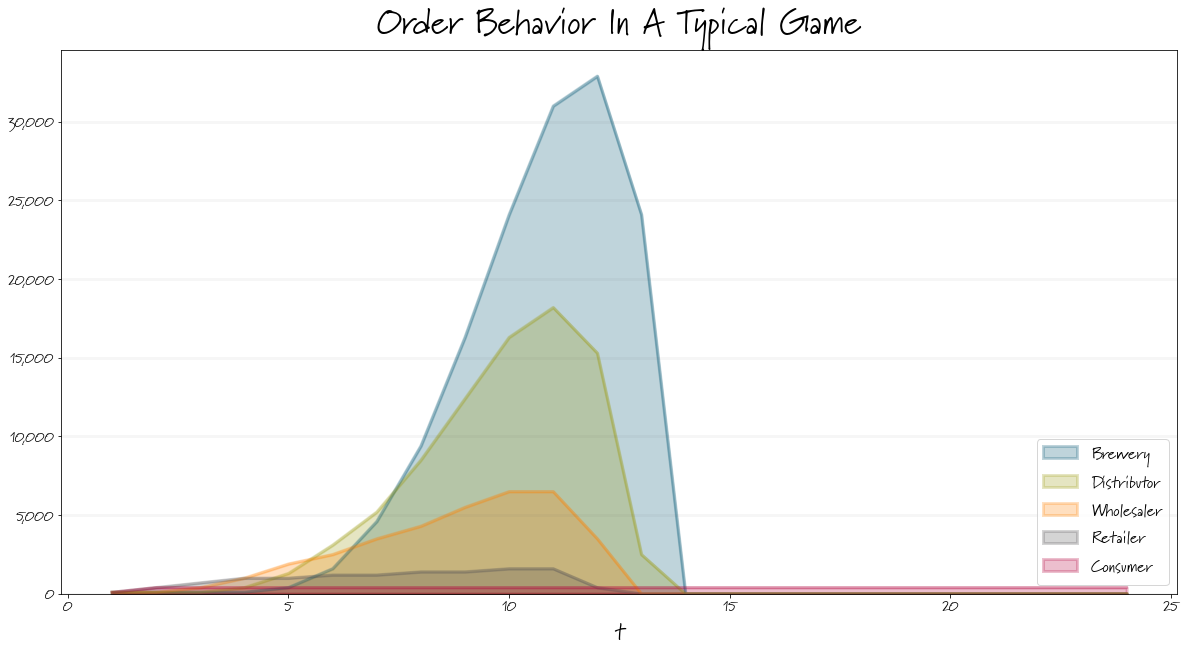

In [3]:
bptk.plot_scenarios(
    scenario_managers=["smBeergame"],
    kind="area",
    title="Order Behavior In A Typical Game",
    scenarios=["typical"],
    agents=["brewery","distributor","wholesaler","retailer","consumer"],
    agent_states=["active"],
    agent_properties=["outgoing_order"],
    agent_property_types=["total"],
    return_df=False,
    series_names={
        "smBeergame_typical_brewery_active_outgoing_order_total" : "Brewery",
        "smBeergame_typical_distributor_active_outgoing_order_total" : "Distributor",
        "smBeergame_typical_wholesaler_active_outgoing_order_total" : "Wholesaler",
        "smBeergame_typical_retailer_active_outgoing_order_total" : "Retailer",
        "smBeergame_typical_consumer_active_outgoing_order_total" : "Consumer"
        
    }
)

With this order behaviour, the supply chain costs are way off target:

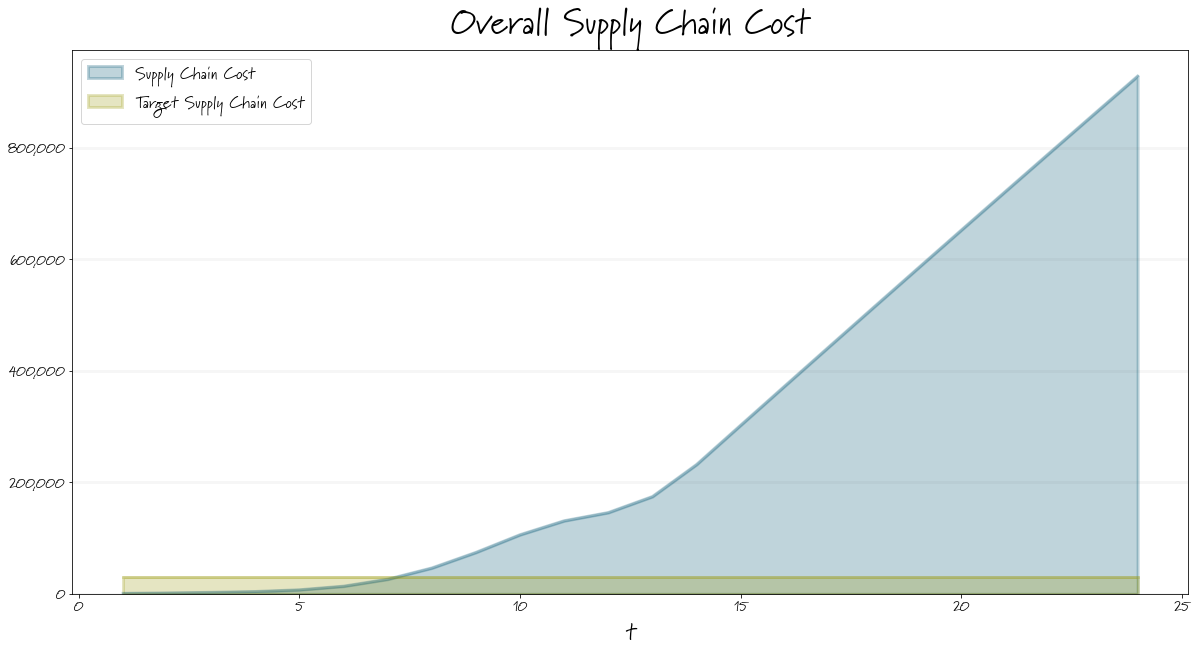

In [3]:
bptk.plot_scenarios(
    scenario_managers=["smBeergame"],
    kind="area",
    title="Overall Supply Chain Cost",
    scenarios=["typical"],
    agents=["controlling"],
    agent_states=["active"],
    agent_properties=["supply_chain_cost","target_supply_chain_cost"],
    agent_property_types=["total"],
    return_df=False,
    series_names={
        "smBeergame_typical_controlling_active_supply_chain_cost_total" : "Supply Chain Cost",
        "smBeergame_typical_controlling_active_target_supply_chain_cost_total" : "Target Supply Chain Cost"
        
    }
)

It is actually quite easy to define ordering policies that will lead to improved behaviour (again it is best to read [Understanding the Beergame](understanding_the_beergame.ipynb) for details).

One simple strategy is to manage the order balance, i.e. the difference between incoming orders (i.e. those coming from the customer) and outgoing orders (i.e. those going to the supplier). Put simply, we would expect the balance to be a constant equal to the desired inventory, a sensible ordering strategy then would be:

`Int(Max(Incoming Order+(2 * Incoming Order+ Target Inventory- Order Balance)/Inventory Adjustment Time),0))`

The graphs below show how orders, inventory and costs develop under this strategy.

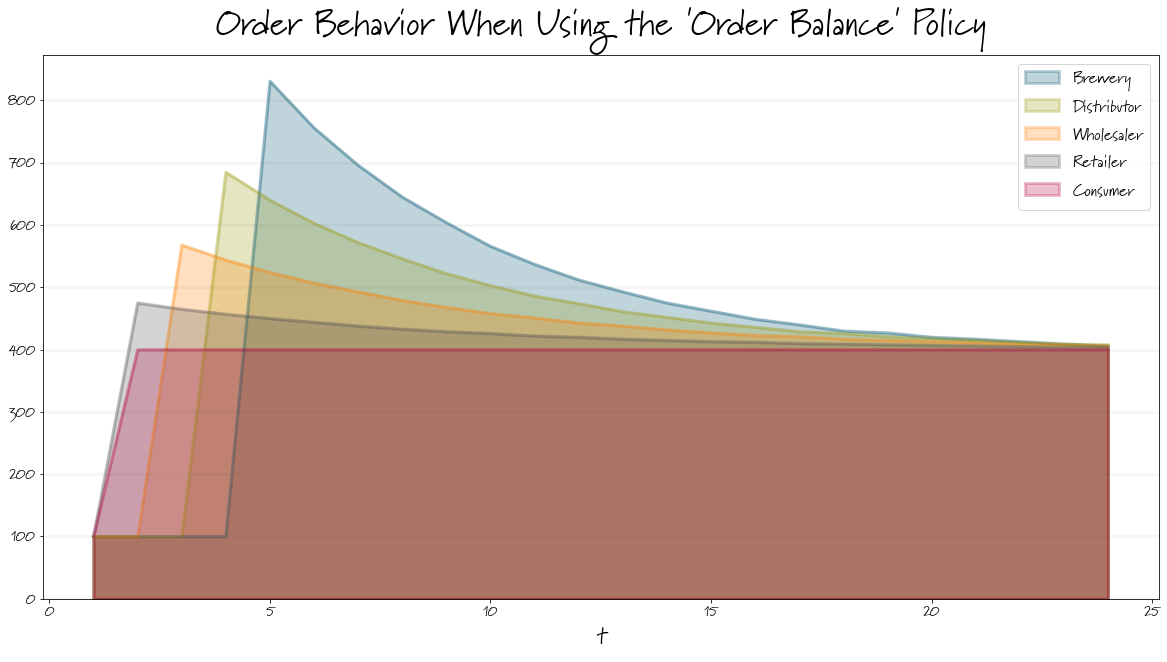

In [4]:
bptk.plot_scenarios(
    scenario_managers=["smSmartBeergame"],
    kind="area",
    title="Order Behavior When Using the 'Order Balance' Policy",
    scenarios=["order_balance"],
    agents=["brewery","distributor", "wholesaler", "retailer","consumer"],
    agent_states=["active"],
    agent_properties=["outgoing_order"],
    agent_property_types=["total"],
    return_df=False,
    series_names={
        "smSmartBeergame_order_balance_brewery_active_outgoing_order_total" : "Brewery",
        "smSmartBeergame_order_balance_distributor_active_outgoing_order_total" : "Distributor",
        "smSmartBeergame_order_balance_wholesaler_active_outgoing_order_total" : "Wholesaler",
        "smSmartBeergame_order_balance_retailer_active_outgoing_order_total" : "Retailer",
        "smSmartBeergame_order_balance_consumer_active_outgoing_order_total" : "Consumer"
        
    }
)

This policy is nice and simple and it is almost good enough to achieve the target of keeping the supply chain costs below $30,000.

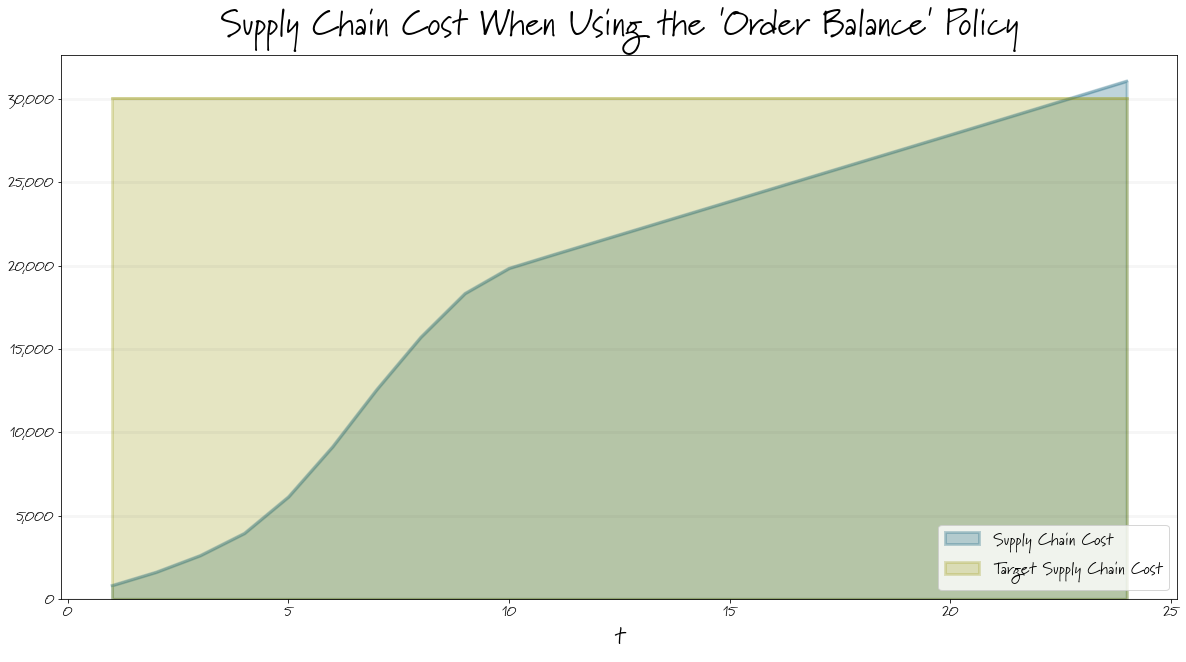

In [5]:
bptk.plot_scenarios(
    scenario_managers=["smSmartBeergame"],
    kind="area",
    title="Supply Chain Cost When Using the 'Order Balance' Policy",
    scenarios=["order_balance"],
    agents=["controlling"],
    agent_states=["active"],
    agent_properties=["supply_chain_cost","target_supply_chain_cost"],
    agent_property_types=["total"],
    return_df=False,
    series_names={
        "smSmartBeergame_order_balance_controlling_active_supply_chain_cost_total" : "Supply Chain Cost",
        "smSmartBeergame_order_balance_controlling_active_target_supply_chain_cost_total" : "Target Supply Chain Cost"
    }
    
)

The objective now is to use machine learning to find an order policy that keeps the actual supply chain costs close to the target supply chain cost, in the following we will do so using a reinforcement learning approach.

### A Brief Introduction To Reinforcement Learning

Reinforcement Learning is a machine learning technique that focuses on learning from interaction: agents interact with their environment according to their "action policy" and receive rewards for their actions. The objective of reinforcement learning algorithms is to learn the right action policies, i.e. to find policies that maximize the rewards the agents receive for their actions.

There are different approaches to reinforcement learning and we will use a simple one known as Q-Learning in this notebook. 

in Q-Learning, each agent has a "Q-Table", which defines the expected total reward an agent will get for performing a particular action when in a particular state. Agents initially start with an "empty" Q-Table and then learn the right behaviour through trial and error. 
 
Agents start with an "empty" q-table and then fill it by learning through trial and error. At each step, an agent always chooses to perform the action that will lead to the highest reward.

![Agents Use Q-Tables To Choose Their Actions](images/q-table.png)

The following paragraphs dive a little deeper into the mathematics behind reinforcement learning. This is quite illustrative because it shows how you can deal with uncertainty and also how to deal with (extrinsic) reward systems – two capabilities that are very important in any enterprise. Feel free to skip to the next chapter if you are not interessted in the mathematical formalism. 

> The following exposition of reinforcement learning closely follows that in the seminal book [Reinforcement Learning](https://www.amazon.com/-/de/dp/0262039249/ref=sr_1_1?__mk_de_DE=ÅMÅŽÕÑ&keywords=reinforcement+learning&qid=1584206411&sr=8-1) by Richard S. Sutton and Andre G. Barto

In order to make reinforcement learning computable, we need to find an apropriate formalism. One such formalism is to model such agent-environment interactions as _Markov Decision Processes_ (MDPs):

At each timestep $t$ the agent receives some representation of the enviroments state, $S_t \in \mathcal{S}$, and on that basis selects an action, $A_t \in \mathcal{A}$. One time step later, (in part) as a consequence of its action, the agent receives a reward $R_t \in \mathcal{R} \subset \mathbb{R}$.

![Agents interact with the environment](images/agent_environment.png)

The interaction then gives rise to a _trajectory_ that looks like this: $S_0,A_0,R_1,S_1,A_1,R_2,S_2,A_2,R_3,...$

In a finite MDP, the sets of states, actions and rewards ($\mathcal{S}$, $\mathcal{A}$ and $\mathcal{R}$) have a finite number of elements and the random variables $R_t$ and $S_t$ have well defined probability distributions that depend only on the preceding state and action:

\begin{equation*}
p\left(s',r \mid s,a\right) = Pr\{S_t=s', R_t=r \mid S_{t-1}=s, A_{t-1}=a\}
\end{equation*}

for all $s',s \in \mathcal{S}, r \in \mathcal{R}$, and $a \in \mathcal{A}(s)$. The function $p$ defines the dynamics of the MDP which defines a probability distribution for each choice of $s$ and $a$:

\begin{equation*}
\sum_{s' \in \mathcal{S}} \sum_{r \in \mathcal{R}} p\left(s',r \mid s,a\right) = 1, \forall s \in \mathcal{S}, a \in \mathcal{A}(s)
\end{equation*}

Using $p$, we can calculate anything we need to know about an agents behaviour, e.g the _state-transition probabilities_:

\begin{equation*}
p\left(s' \mid s,a\right) = Pr\{S_t=s'\mid S_{t-1}=s, A_{t-1}=a\}=\sum_{r \in \mathcal{R}} p\left(s',r \mid s,a\right)
\end{equation*}

In particular, we can calculate the expected reward if we are in state $s$ and choose action $a$:

\begin{equation*}
r\left(s,a\right) =  \mathbb{E} \lbrack R_t \mid S_{t-1}=s, A_{t-1}=a \rbrack = \sum_{r \in \mathcal{R}} r \sum_{s' \in \mathcal{S}} p\left(s',r \mid s,a\right)
\end{equation*}

#### Goals and Rewards

In order to get our agents to learn, we not only need to define the reward an agent gets for performing an action, we also need to tell the agents to maximize the sum of rewards over its lifetime, i.e the lifetime reward.

Formally we can define the objective of reinforcement learning to maximize the expected lifetime reward, which is defined as:

\begin{equation*}
G_t \doteq R_{t+1}+\gamma R_{t+2}+\gamma^2 R_{t+3} +\dots = \sum_{k=0}^\infty \gamma^k R_{t+k+1} 
\end{equation*}

where $0 \leq \gamma \leq 1$ is the _discount rate_ (which is needed to ensure $G$ converges in infinite MDPs).

Note that $G$ can also be defined recursively:

\begin{equation*}
G_t = R_{t+1}+\gamma G_{t+1}
\end{equation*}

#### Action Policies

Now that we know we want to optimize the liftetime reward, we need to help our agent to learn an optimal policy. A _policy_ is a mapping from states to the probability of selecting a possible action. 

If the agent is following policy $\pi$ at time $t$, then $\pi(a \mid s)$ is the probability that $A_t=a$ if $S_t=s$.

Note that $\pi$ is distinct from the probability distribution $p$ defined above – the probability distribution $p$ gives us information about the environment, it tells us the reward an agent will get for performing certain actions and which state the agent will transition to; the probability distribution $\pi$ gives us information about the agent itself, it tells us the probabilty an agent will choose a particular action in a particular situation.

This is illustrated in the diagram below.

![Backup Diagram](images/backup_diagram.png)

Given $\pi$ and $p$ we can calulate the probability an agent will transition into a particular state $s'$ given that it is in state $s$:

\begin{equation*}
p_\pi (s' \mid s) =  \sum_a \pi(a \mid s) \sum_{r} p\left(s',r \mid s,a\right)
\end{equation*}

and the expected reward when transitioning from state s at time t:

\begin{equation*}
r_\pi (s) = \mathbb{E}_{\pi}\lbrack R_{t+1} \mid S_t=s \rbrack =  \sum_{r} r  \sum_a \pi(a \mid s)  \sum_{s'}  p\left(s',r \mid s,a\right)
\end{equation*}

#### Value Functions

Using the action policy $pi$ and the environment dynamic $p$, we can now calculate the value we expect to achieve from the policy: The _value function_ of a state $s$ under a policy $\pi$, denoted $v_\pi (s)$, is the expected return when starting in $s$ and following $\pi$ thereafter.

For our MDPs, we can define $v_\pi$ by:

\begin{equation*}
v_\pi (s) \doteq \mathbb{E}_{\pi}\lbrack G_t \mid S_t=s \rbrack = \mathbb{E}_{\pi}\lbrack \sum_{k=0}^\infty \gamma^k R_{t+k+1} \mid S_t=s \rbrack, \forall s \in S 
\end{equation*}

We can then define value of taking action $a$ in state $s$ under a policy $\pi$ as follows:

\begin{equation*}
q_\pi (s,a) \doteq \mathbb{E}_{\pi}\lbrack G_t \mid S_t=s, A_t=a \rbrack = \mathbb{E}_{\pi}\lbrack \sum_{k=0}^\infty \gamma^k R_{t+k+1} \mid S_t=s, A_t=a \rbrack, \forall s \in S, a \in A
\end{equation*}

$q_\pi$ is called the _action value function for policy $\pi$_. It represents the expected value of our policy if we start in state $s$, then take action $a$ and follow the policy $\pi$ thereafter. The important point here is that $q_\pi$ not only captures the immediate reward we get for our next action, but also the expected reward the agent will get thereafter.

#### Bellmann Equation

Given the recursive nature of the lifetime reward, we can answer the question of how the value of an agents current state is related to the value of its future state if it follows a policy and takes an action now: after all, once we have transitioned from $s$ to $s'$, nothing changes from a conceptual perspective.

\begin{align}
v_\pi (s) & \doteq \mathbb{E}_\pi \lbrack G_t \mid S_t=s \rbrack \\
& = \mathbb{E}_{\pi}\lbrack R_{t+1}+\gamma G_{t+1} \mid S_t=s \rbrack \\
& = \mathbb{E}_{\pi}\lbrack R_{t+1} \mid S_t=s \rbrack +\gamma \mathbb{E}_{\pi}\lbrack G_{t+1} \mid S_t=s \rbrack
\end{align}

The first summand here is simply the reward we expect from taking an action and moving from $s$ to $s'$, more explicitly:

\begin{equation*}
r_\pi (s) = \mathbb{E}_{\pi}\lbrack R_{t+1} \mid S_t=s \rbrack =  \sum_{r} r  \sum_a \pi(a \mid s)  \sum_{s'}  p\left(s',r \mid s,a\right)
\end{equation*}


The second part is slightly more complicated – it defines the expected lifetime reward from time $t+1$ but starting at time $t$ in state $s$. To calculate this we need to calculate the value function for each potential future state $s'$, weighted by the probability of actually getting to that state:


\begin{equation*}
\mathbb{E}_{\pi}\lbrack G_{t+1} \mid S_t=s \rbrack  = \sum_{s'} v_\pi (s')  p_\pi (s' \mid s) = \sum_{s'} v_\pi (s') \sum_a \pi(a \mid s) \sum_{r} p\left(s',r \mid s,a\right) 
\end{equation*}

The second part of the equation is visualized in the diagram below.

![Bellmann Equation](images/bellmann.png)

Putting these terms together and rearranging the sums, we end up with:

\begin{equation*}
v_\pi (s) =  \sum_a \pi(a \mid s)\sum_{s'} \sum_{r} p\left(s',r \mid s,a\right)\lbrack r+\gamma v_\pi (s')\rbrack 
\end{equation*}

This is known as the _Bellmann equation for $v_\pi$_. It expresses a relationship between the value of a state and the values of successor states: The value of the start state must equal the (discounted) value of the expected next state, plus the reward expected in getting to that state.

#### Optimal Policies and the Optimal Value Function

Now that we know about policies and value functions, we can try looking for the best possible, optimal value function. i.e. the one that achieves the highest reward over the long run.

Using value functions, we can define an ordering of policies: $\pi \geq \pi'$ if and only if $v_\pi (s) \geq v_{\pi'} (s)$ for all $s \in \mathcal{S}$.

There will always be at least one policy that is better than or equal to all other policies – this is an _optimal policy_. Let's denote this by $\pi_*$, which has the _optimal state-value function_ $v_*$, defined as:

\begin{equation*}
v_* (s) \doteq \max\limits_\pi v_\pi (s)
\end{equation*}

Optimal policies share the same _optimal action-value function_ $q_*$, defined as

\begin{align}
q_* (s) & \doteq   \max\limits_\pi q_\pi (s,a) \\
& = \mathbb{E}\lbrack R_{t+1}+\gamma v_* (S_{t+1}) \mid S_t=s, A_t=a \rbrack 
\end{align}

Because $v_*$ is the value function for a policy, it must satisfy the Bellmann equation. However, because it is the optimal value function, we can actually write this in a special form without reference to any specific policy. This form is called the _Bellmann optimality equation_:

\begin{align}
v_* (s) & = \max\limits_\pi q_\pi (s,a) \\
& = \max\limits_a \mathbb{E}_{\pi_*}\lbrack R_{t+1}+\gamma G_{t+1} \mid S_t=s, A_t=a \rbrack  \\
& = \max\limits_a \mathbb{E}_{\pi_*}\lbrack R_{t+1}+\gamma v_* (S_{t+1}) \mid S_t=s, A_t=a \rbrack \\
&= \max\limits_a  \sum_{s', r} p\left(s',r \mid s,a\right)\lbrack r+\gamma v_* (s')\rbrack
\end{align}

>Intuitively, the Bellmann optimality equation expresses the fact that the value of a state under an optimal policy must equal the expected return for the best action from that state.

The Bellmann optimality equation for $q_*$ is:

\begin{align}
q_* (s,a) & =  \mathbb{E}\lbrack R_{t+1}+\gamma \max\limits_{a'} q_* (S_{t+1},a') \mid S_t=s, A_t=a \rbrack \\
&=  \sum_{s', r} p\left(s',r \mid s,a\right)\lbrack r+\gamma \max\limits_{a'}  q_* (s',a')\rbrack
\end{align}

#### Solving The Bellman Equation: Temporal Difference Learning / Q-Learning

Reinforcement learning then essentially boils down to solving the Bellman optimality equation. For finite MDPs, such a solution will always exist - because the Bellman optimality equation defines a system of equations, once for each state. So if there are $n$ states, you end up with $n$ equations in $n$ unknowns. 

Once you have $v_*$, it is quite easy to derive the optimal policy: for each state $s$, there will be at least one state for which the maximum is obtained in the Bellman optimality equation. Any policy that assigns nonzero probability only to these actions is an optimal policy.

If you have $q_*$, choosing an optimal policy is even easier - you simply have to find an action that maximises $q_* (s,a)$:

\begin{align}
\pi_* (a \mid s) & > 0, a \in argmax_a q_*(s,a) \\
\pi_* (a \mid s) & = 0, a \notin argmax_a q_*(s,a)
\end{align}

Because the state-space can be extremely large, it is rarely practical to find an exact solution to $v_*$ or $q_*$. Fortunately a number of approaches exist to finding approximate solutions.

One way of estimating $v$ is to use a Monte-Carlo approach: we start with an initial approximation $V$ for $v$ (i.e. for the expected total reward folling that state) and then run through our simulation a large number of times - each time we run the simulation we will wander through a different trajectory defined by $pi_*$ and the environment dynamic $p$.

During each run we cache the actual value for $G_t$ (i.e. the actual total reward following that state) for each state and timestep. At the end of the run we update $V(S_t)$ using the following formula, where $\alpha$ is a constant that defines how quickly we move towards the new value:

\begin{equation*}
V(S_t) \gets V(S_t) + \alpha \lbrack G_t - V(S_t) \rbrack
\end{equation*}

The Monte-Carlo approach works fine, but it does have one issue: you need to wait until the end of each simulation to actually calculate $G_t$, which means this process is very slow.

Fortunately there is a much faster approach, which allows us to update $V$ after each timestep. This approach works thanks to the recursive nature of the Bellman equation.

Remembering that $G_t = R_{t+1}+\gamma G_{t+1}$, we can use the following formula to update $V$ after every timestep:

\begin{equation*}
V(S_t) \gets V(S_t) + \alpha \lbrack R_{t+1}+\gamma V(S_{t+1}) - V(S_t) \rbrack
\end{equation*}

This approach to learning is referred to as _Temporal Difference Learning_, because it compare values of $V$ that are separated by a (short) temporal difference.

In this notebook we focus on a variant of temporal difference learning known as  _Q-Learning_ because it finds a solution for $q_*$ instead of $v_*$:

\begin{equation*}
Q(S_t,A_t) \gets Q(S_t,A_t) + \alpha \lbrack R_{t+1}+\gamma \max\limits_a Q(S_{t+1},a) - Q(S_t,A_t) \rbrack
\end{equation*}

Given this, we can define the basic Q-learning algorithm as follows:


Start with an initial (random) $Q(s,a)$, ensuring that $Q(terminal state,.) = 0$

Run the simulation a large number of times (episodes), with the following loop for each episode:


1. Initialize S
2. Loop for each step of episode
    1. Choose A from S using $\epsilon$-greedy policy based on Q
    2. Take action A, observe R, S'
    3. $Q(S_t,A_t) \gets Q(S_t,A_t) + \alpha \lbrack R_{t+1}+\gamma \max\limits_a Q(S_{t+1},a) - Q(S_t,A_t) \rbrack$
    * $S \gets S'$
3. Until S is terminal or simulation reaches a predefined end

We use the $epsilon$-greedy policy in step 2.1 to ensure that our algorithm doesn't get locked into a local optimum: using a small $\epsilon > 0$ that defines a probability that we will choose a random action instead of one defined by our policy ($\epsilon$-greedy approach).

The step size $\alpha \in (0, 1\rbrack$ defines how quickly we move from our current value of $Q$ to a new value and $\gamma$ is the discounting factor.

### Applying Q-Learning To The Beergame

Now let's apply the theory above to our beergame agents. Our "learning" consists of finding the right values for the function $Q(S,A)$, which tells the agent which action to take if it is in State A.

We set $\epsilon=0.1$ and $\alpha=0.2$. Because the beergame runs over a finite set of 24 rounds, we can set $\gamma=1$.

We store $Q$ in a _Q-Table_, which is essentially a matrix indexed by the state of the agent and possible actions. For each entry, we store the value $Q(S,A)$, which is our approximation of the optimal value $q(s,a)$, i.e. the value we expect to achieve if we are in state $s$ and choose action $a$.


Because the number of states and actions is potentially infinite (an agent can order any amount of beer), we use a sparse q-table, i.e. a table that is empty and just stores the values that differ from the default value. Our implementation of the q-table `sparseQTable` stores values in a dictionary whose key is defined by the tuple $(s,a)$. For the beergame, we set the default value to 0, i.e. we expect 0 value from an action we have never tried before.

Next to adding and reading values, the q-table provides two key methods:

* __best_action(state)__ This method returns the best action for a given state, i.e. the action that maximes $Q(S,A)$ for a given state $S$.
* __max_action_value(state)__ This method returns the best value that can be achieved for a given state, i.e. $Q(S, best\_action(S))$.

Each supply chain agent has its own Q-table and we capture the agents state via a single value, namely the __order balance__ introduced above.

The implementation of the actual training algorithm is remarkably simple, which is why we have included the complete code below.

Each agent rembers its `last_state` and its `last_action`, which is equal to the order of beer that is placed by the agent.

```python

# read the last action value from the q table
        last_action_value = self.q_table.read_value(
                self.last_state,
                self.last_action
        )

# define the current state, which is the last order balance modified by the incoming order

        current_state = self.agent.order_balance-self.agent.incoming_order

# work out the next action value for the current state, which is the order balance minus the new incoming order

        max_next_action_value = self.q_table.max_action_value((current_state,))
    
# work out the new action value based on the q-learning algorithm introduced above - this is necessary because the reward is calculated at the end of the step, i.e the update can only be done in the next timestep.

        new_action_value = (
            last_action_value +
            self.agent.model.alpha*(
                self.agent.reward + 
                self.agent.model.gamma * max_next_action_value -
                last_action_value
            )
        )

# update the action value for the last state and the last action
    
        self.q_table.add_value(self.last_state, self.last_action, new_action_value)
    
# now decide  on which action to take, either by looking up the best value in the q-table or by choosing a random number (𝜖-greedy approach)

        if random.uniform(0, 1) < self.agent.model.epsilon:
            # once in a while we choose a random amount to ensure we are not locked into a local maximum
            order_amount =  random.randint(0, round(1.5*self.agent.incoming_order)) 
        else:
            # look up the best action for this state in the q-table
            order_amount = self.q_table.best_action((current_state,))
            
# now remember the state and action taken, as a starting point for the next round
        self.last_state = (current_state,)
        self.last_action = order_amount
```

As you can see, this is simply a concrete implementation of the abstract q-learning algorithm defined above.

Next we need to think about the reward we want to give the agents for their performance. We have to be quite careful here because we know what a good order strategy should look like and we want to avoid coding the strategy directly into the rewards.

In principle, it is quite simple to define rewards: the objective of the game is to keep both the total supply chain cost and also the individual supply chain cost within certain targets. In order to do this in an efficient manner, it makes sense to define some milestones along the way and also to stop a game as soon as the agents miss their target.

![Finding The Right Rewards](images/supply_chain_rewards.png)

Clearly then we need to give the agents a high reward if they achieve these targets - the rewards are distributed at the end of each round in the `end_round` method of the simulation model.

```python
if time == self.stoptime - 1: # penultimate round, to ensure rewards are handled in final round
    if agent.total_cost < 10000:
         reward += 10000
    if controlling_agent.supply_chain_cost < 40000:
         reward += 20000
                           
```

The only issue here is that this is a reward that comes right at the end of the game and things can go very wrong long before we get to the end.

Which guidance can we give the agents along the way?

The first thing we can do is to penalize the agents as soon as they miss the game target (which can happen very early on in the game). In this case we penalize the agents and stop the game for that episode to avoide filling the q-table with unnecessary information. We also penalize the agents if they don't order at least as much as the incoming order.

```python
 if (agent.order_balance < 0  or agent.order_balance > 1400):
                    self.game_over = True
                    self.game_over_round = time + 1 # run one more round to pickup the rewards, then stop
                    reward = -10000
                elif agent.outgoing_order < agent.incoming_order:
                    reward = -10000

```

Unfortunately this still leaves us with very many possible paths, especially given the fact that we are training not only one agent but a whole supply line. Thus to make the learning process a little quicker and keep our q-table small, we define some milestones along the way:

```python

if time == 3:
                        if 750 >= agent.order_balance >= 600:
                            reward += 2000
                    if time == 5:
                        if 900 >= agent.order_balance >= 700:
                            reward += 2000      
                    if time == 10:
                        if 1150 >= agent.order_balance >= 1000:
                            reward += 2000      
                    if time == 15:
                        if 1250 >= agent.order_balance >= 1100:
                            reward += 2000
                    if time == 20:
                        if 1250 >= agent.order_balance >= 1150:
                            reward += 2000

```

Now let's see how this works out in practice. The following code runs the beergame over ten epsiodes and returns the total supply chain reward ... in the long run we would like the reward to become less and less negative.

FloatProgress(value=0.0, bar_style='info', description='Running', max=1.0)

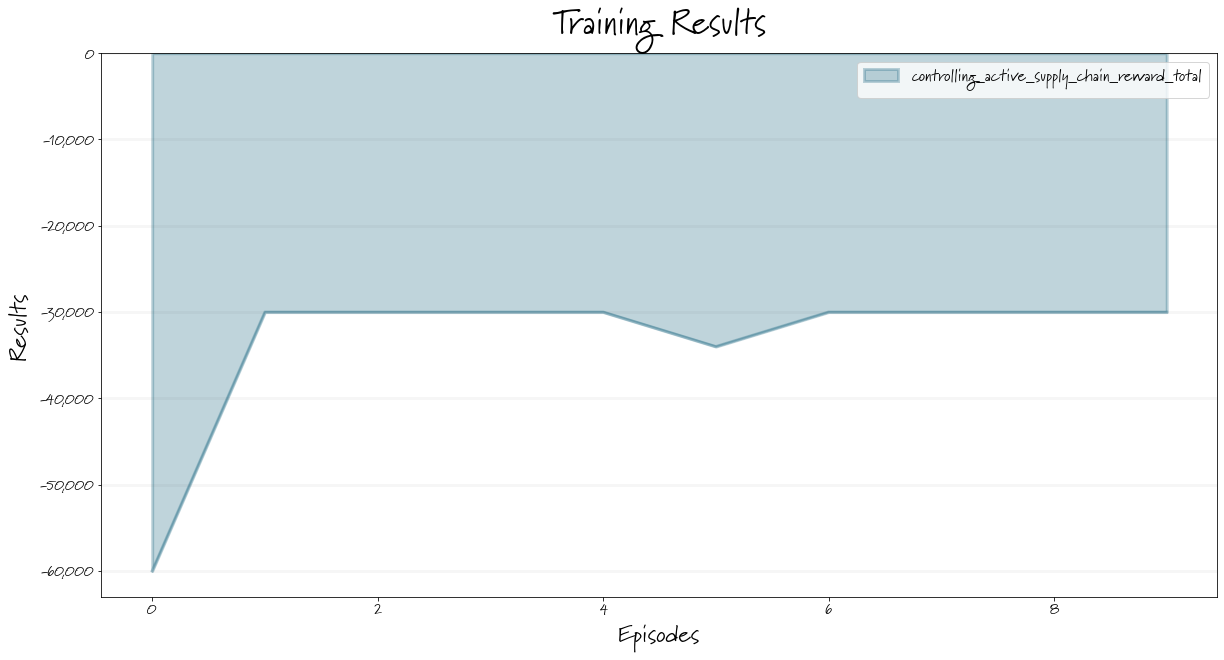

In [6]:
bptk.train_simulations(
    episodes=10,
    scenario_managers=["smBeergameQlOB"],
    scenarios=["train_agents"],
    agents=["controlling"],
    agent_states=["active"],
    agent_properties=["supply_chain_reward"],
    agent_property_types=["total"],
    return_df=False,
    progress_bar=True,
    series_names={
        "smBeergameQlOB_train_agents_controlling_active_supply_chain_reward_total" : "Supply Chain Reward"
    }
)

We can use the trained model as follows:

In [7]:
bptk.reset_scenario(scenario_manager="smBeergameQlOB",scenario="smart_agents")

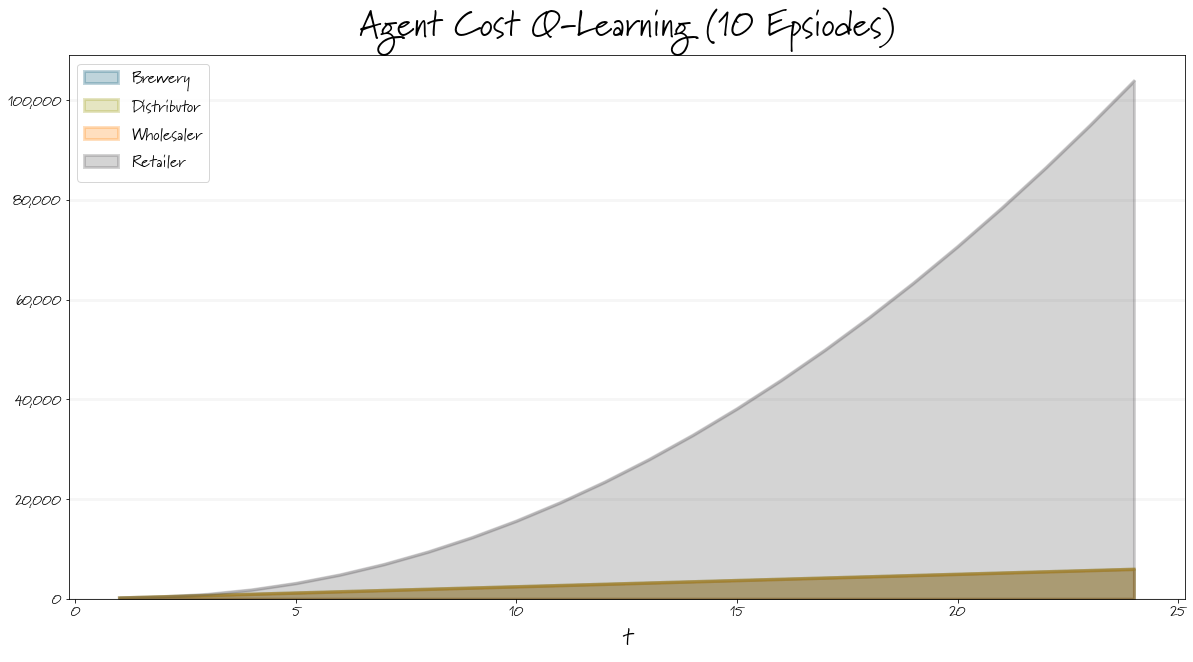

In [8]:
bptk.plot_scenarios(
    scenario_managers=["smBeergameQlOB"],
    kind="area",
    title="Agent Cost Q-Learning (10 Epsiodes)",
    scenarios=["smart_agents"],
    agents=["brewery","distributor","wholesaler","retailer"],
    agent_states=["active"],
    agent_properties=["total_cost"],
    agent_property_types=["total"],
    series_names={
        "smBeergameQlOB_smart_agents_brewery_active_total_cost_total" : "Brewery",
        "smBeergameQlOB_smart_agents_distributor_active_total_cost_total" : "Distributor",
        "smBeergameQlOB_smart_agents_wholesaler_active_total_cost_total" : "Wholesaler",
        "smBeergameQlOB_smart_agents_retailer_active_total_cost_total" : "Retailer",
        "smBeergameQlOB_smart_agents_consumer_active_total_cost_total" : "Consumer"
        
    }
)

We can see that the agents haven't learnt much after ten trainig episodes  ... the retailer is ordering far too much, producing very high costs.

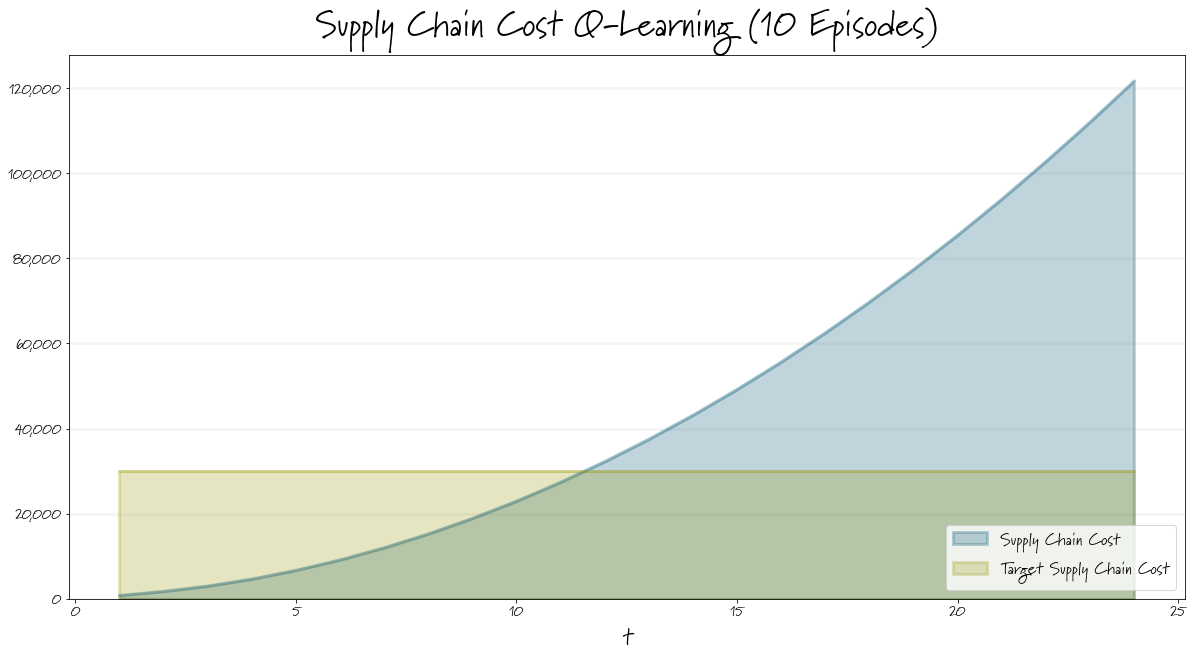

In [9]:
bptk.plot_scenarios(
    scenario_managers=["smBeergameQlOB"],
    kind="area",
    title="Supply Chain Cost Q-Learning (10 Episodes)",
    scenarios=["smart_agents"],
    agents=["controlling"],
    agent_states=["active"],
    agent_properties=["supply_chain_cost","target_supply_chain_cost"],
    agent_property_types=["total"],
    series_names={
        "smBeergameQlOB_smart_agents_controlling_active_supply_chain_cost_total" : "Supply Chain Cost",
        "smBeergameQlOB_smart_agents_controlling_active_target_supply_chain_cost_total" : "Target Supply Chain Cost"
    }
)

Actually, training the agents takes quite a few episodes and it takes around 50,000 epsiodes to produce satisfactory results (this is still small if you consider the number of potential paths, which is essentially infinite because the agents could order any amount of beer). Because it takes 2-3 of hours to run that many epsiodes (on a Macbook Pro with 16 GB of RAM), we've provided pretrained q-tables for 12500, 25000, 37500 and 50000 for you to experiment with (see the `data` directory of this repository).

To use them you first need to reset the q-tables:

In [10]:
from src.q_learning_base.sparseQTable import SparseQTable
from src.q_learning_ob.beergame import BeergameQlOB

In [11]:
BeergameQlOB.brewery_q_table=SparseQTable(dimension=1)
BeergameQlOB.distributor_q_table=SparseQTable(dimension=1)
BeergameQlOB.wholesaler_q_table=SparseQTable(dimension=1)
BeergameQlOB.retailer_q_table=SparseQTable(dimension=1)

Then load the previously saved q-tables:

In [12]:
BeergameQlOB.load_q_tables("data/q_tables_37500.json","JSON")

We can check the size of the q-tables as follows:

In [13]:
print("Q-Table Counts")
print("Brewery: {}".format(BeergameQlOB.brewery_q_table.count()))
print("Distributor: {}".format(BeergameQlOB.distributor_q_table.count()))
print("Wholesaler: {}".format(BeergameQlOB.wholesaler_q_table.count()))
print("Retailer: {}".format(BeergameQlOB.retailer_q_table.count()))

Q-Table Counts
Brewery: 17159
Distributor: 18526
Wholesaler: 18659
Retailer: 10985


Reset the scenario to ensure the scenarios pick up the new q-tables:

In [14]:
bptk.reset_scenario(scenario_manager="smBeergameQlOB",scenario="smart_agents")

Now we can take a look at the results - it looks quite good already after 37500 training episodes, but the retailers cost are still a little high.

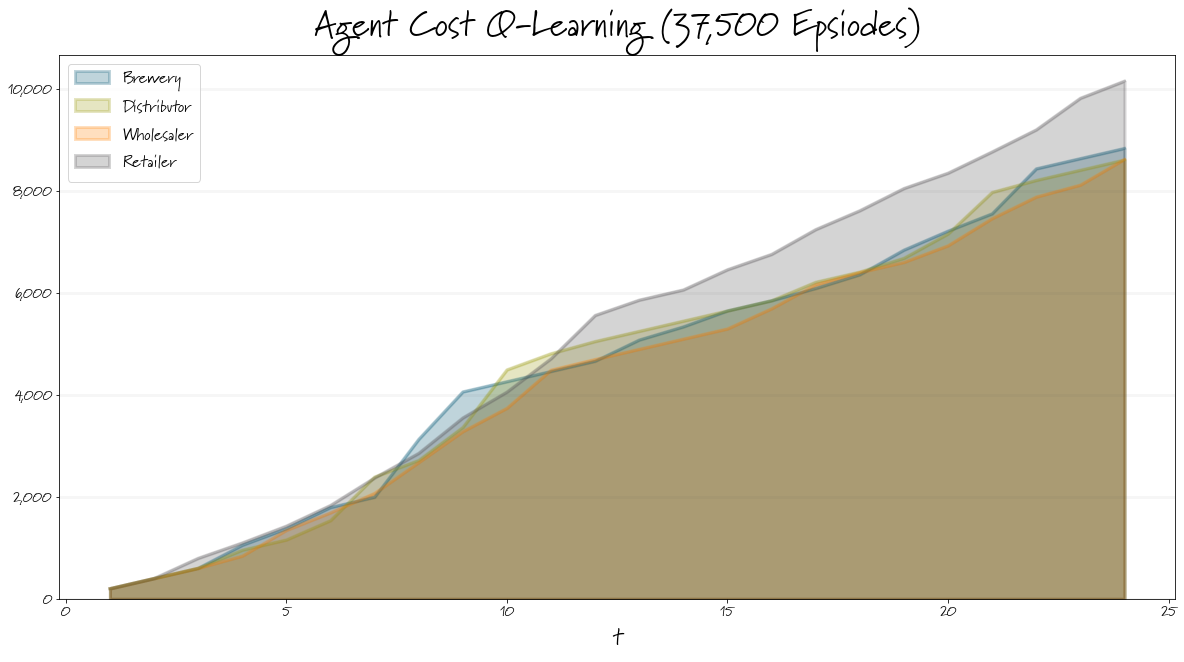

In [15]:
bptk.plot_scenarios(
    scenario_managers=["smBeergameQlOB"],
    kind="area",
    title="Agent Cost Q-Learning (37,500 Epsiodes)",
    scenarios=["smart_agents"],
    agents=["brewery","distributor","wholesaler","retailer"],
    agent_states=["active"],
    agent_properties=["total_cost"],
    agent_property_types=["total"],
    series_names={
        "smBeergameQlOB_smart_agents_brewery_active_total_cost_total" : "Brewery",
        "smBeergameQlOB_smart_agents_distributor_active_total_cost_total" : "Distributor",
        "smBeergameQlOB_smart_agents_wholesaler_active_total_cost_total" : "Wholesaler",
        "smBeergameQlOB_smart_agents_retailer_active_total_cost_total" : "Retailer",
        "smBeergameQlOB_smart_agents_consumer_active_total_cost_total" : "Consumer"
        
    }
)

Thus, the total supply chain costs are still a little to high:

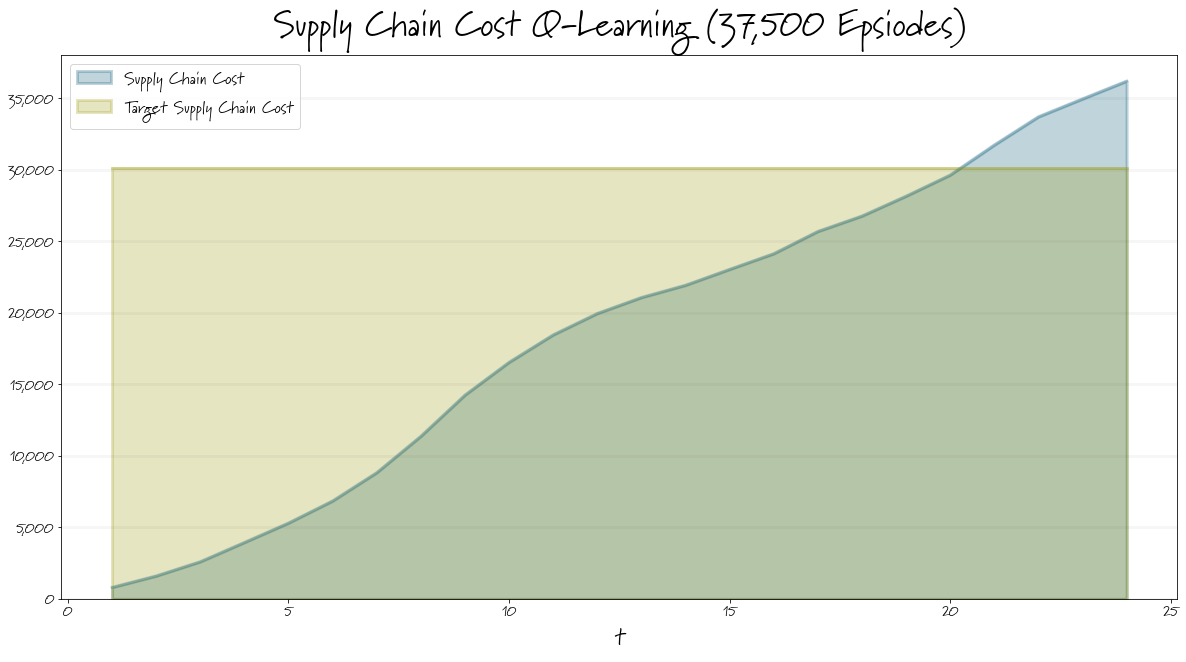

In [16]:
bptk.plot_scenarios(
    scenario_managers=["smBeergameQlOB"],
    kind="area",
    title="Supply Chain Cost Q-Learning (37,500 Epsiodes)",
    scenarios=["smart_agents"],
    agents=["controlling"],
    agent_states=["active"],
    agent_properties=["supply_chain_cost","target_supply_chain_cost"],
    agent_property_types=["total"],
    series_names={
        "smBeergameQlOB_smart_agents_controlling_active_supply_chain_cost_total" : "Supply Chain Cost",
        "smBeergameQlOB_smart_agents_controlling_active_target_supply_chain_cost_total" : "Target Supply Chain Cost"
    }
)

So let's see what happens after 50,000 episodes:

In [17]:
BeergameQlOB.brewery_q_table=SparseQTable(dimension=1)
BeergameQlOB.distributor_q_table=SparseQTable(dimension=1)
BeergameQlOB.wholesaler_q_table=SparseQTable(dimension=1)
BeergameQlOB.retailer_q_table=SparseQTable(dimension=1)

In [18]:
BeergameQlOB.load_q_tables("data/q_tables_50000.json","JSON")

In [19]:
bptk.reset_scenario(scenario_manager="smBeergameQlOB",scenario="smart_agents")

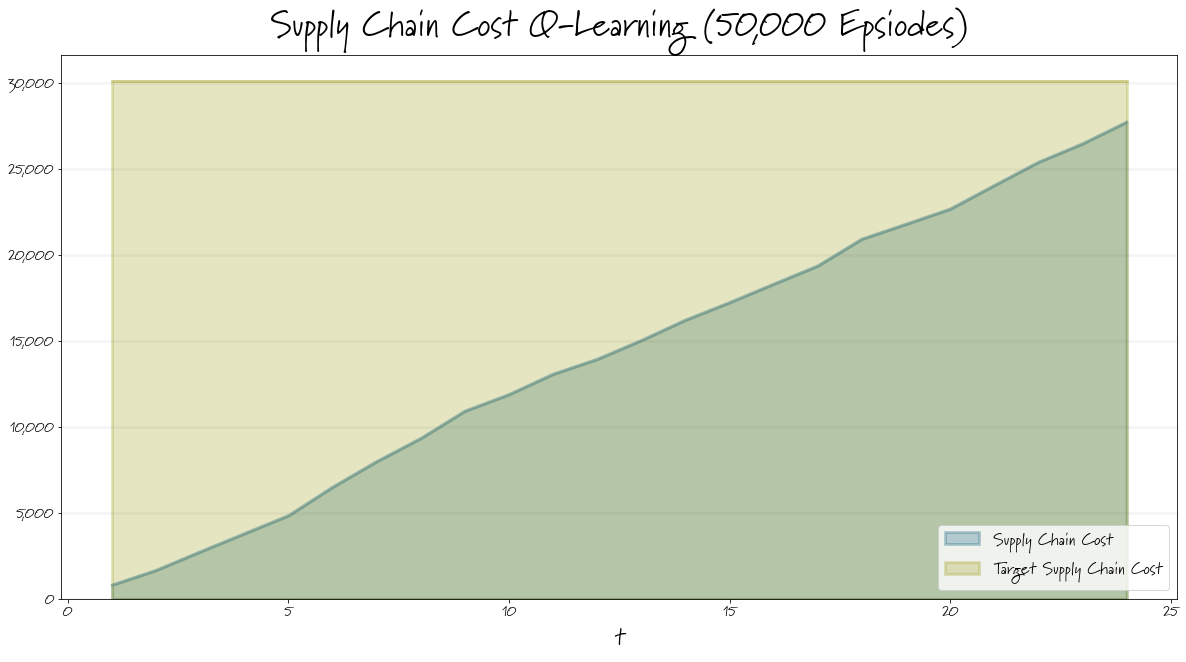

In [20]:
bptk.plot_scenarios(
    scenario_managers=["smBeergameQlOB"],
    kind="area",
    title="Supply Chain Cost Q-Learning (50,000 Epsiodes)",
    scenarios=["smart_agents"],
    agents=["controlling"],
    agent_states=["active"],
    agent_properties=["supply_chain_cost","target_supply_chain_cost"],
    agent_property_types=["total"],
    series_names={
        "smBeergameQlOB_smart_agents_controlling_active_supply_chain_cost_total" : "Supply Chain Cost",
        "smBeergameQlOB_smart_agents_controlling_active_target_supply_chain_cost_total" : "Target Supply Chain Cost"
    }
)

After 50,000 rounds of training, the total costs are within the target and so are the individual costs:

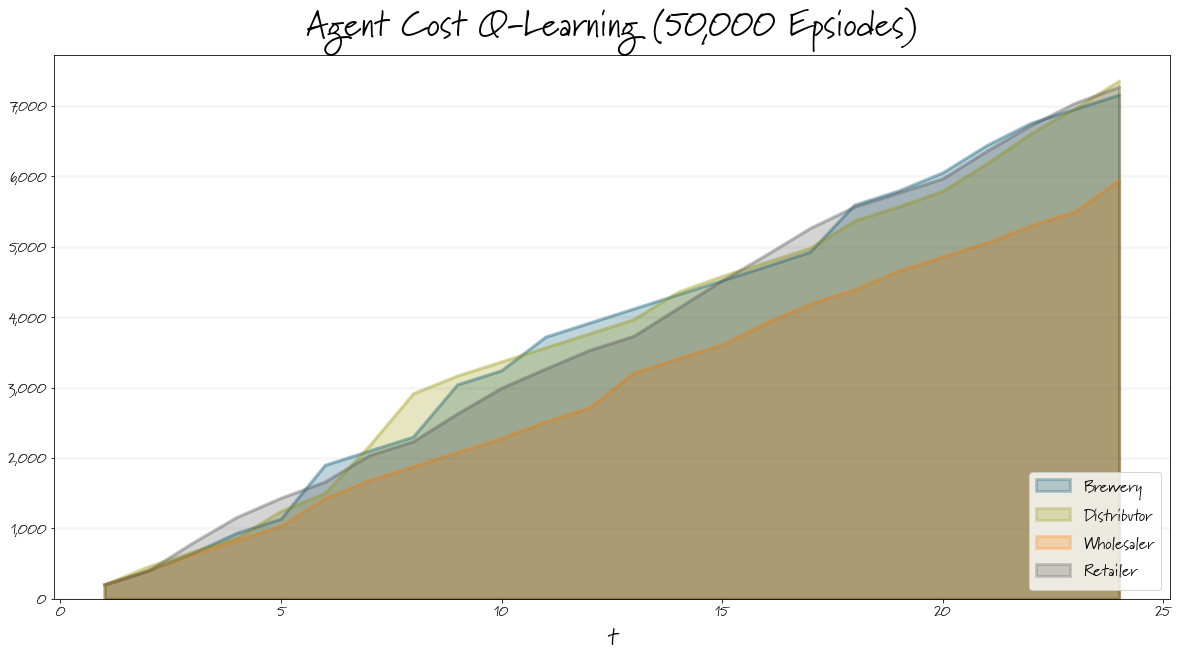

In [21]:
bptk.plot_scenarios(
    scenario_managers=["smBeergameQlOB"],
    kind="area",
    title="Agent Cost Q-Learning (50,000 Epsiodes)",
    scenarios=["smart_agents"],
    agents=["brewery","distributor","wholesaler","retailer"],
    agent_states=["active"],
    agent_properties=["total_cost"],
    agent_property_types=["total"],
    series_names={
        "smBeergameQlOB_smart_agents_brewery_active_total_cost_total" : "Brewery",
        "smBeergameQlOB_smart_agents_distributor_active_total_cost_total" : "Distributor",
        "smBeergameQlOB_smart_agents_wholesaler_active_total_cost_total" : "Wholesaler",
        "smBeergameQlOB_smart_agents_retailer_active_total_cost_total" : "Retailer",
        "smBeergameQlOB_smart_agents_consumer_active_total_cost_total" : "Consumer"
        
    }
)

It is interesting to compare the results of our rule-based ordering policy to the q-learning approach - the approach learned using q-learning actualy performs better. While the 'Order Balance' policy is robust and works whatever the order behaviour of an agent in the supply line, the q-learning algorithm is trained towards a particular order behavior.

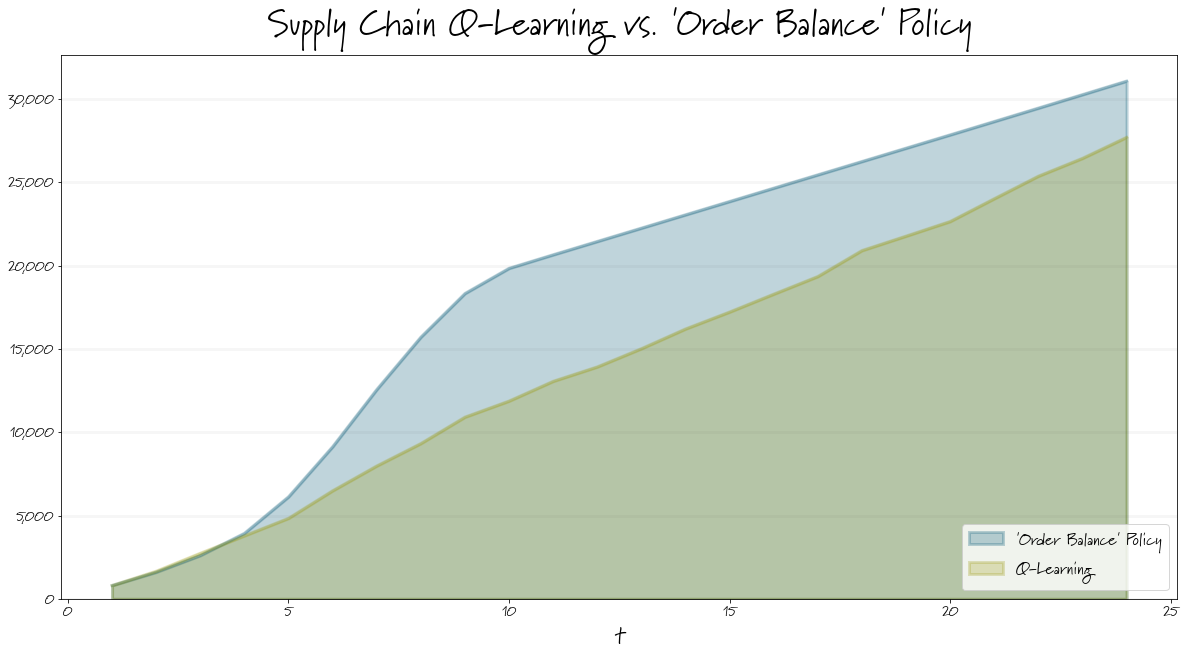

In [22]:
bptk.plot_scenarios(
    scenario_managers=["smBeergameQlOB","smSmartBeergame"],
    kind="area",
    title="Supply Chain Q-Learning vs. 'Order Balance' Policy",
    scenarios=["smart_agents","order_balance"],
    agents=["controlling"],
    agent_states=["active"],
    agent_properties=["supply_chain_cost"],
    agent_property_types=["total"],
    series_names={
        "smBeergameQlOB_smart_agents_controlling_active_supply_chain_cost_total" : "Q-Learning",
        "smSmartBeergame_order_balance_controlling_active_supply_chain_cost_total" : "'Order Balance' Policy"
    }
)

### Summary

This notebook introduced the concept of agent-based simulation and reinforcement learning and applied them to a simple supply chain simulation that simulates the Beer Distrbution Game.

It illustrates how simulations can be used to create a computational model of reality and how reinforcement learning can then be used to find good decision making policies - in our case, the policy found through reinforcement learning actually performs better than the rule-based policy.

The main issue in reinforcement learning is finding the right reward policies and in the end the agents are trained towards those policies - for our beergame simulation this means that are agents are now good at playing the beergame for the given behaviour of the consumer. But if the consumer changes his behaviour, the agents will not know how to deal with this. This is actually quite similar to real life situations, where it is quite difficult to set sensible extrinsic rewards.

In our case the rule-based ordering policy is so simple that an extrinisic reward system would most likely just end up encoding that policy as a set of extrinisic rewards.